# Анализ пользовательского поведения в мобильном приложении

## Вступление

### Описание проекта

Вы предстаём работником в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

### Цель проекта

Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

### Задача проекта

Провести исследование пути покупки пользователями, провести анализ результатов А/А/В теста по замене шрифтов в приложении. Нам предстоит выяснить какой шрифт лучше и ответить на вопросы.


### План проекта

- Откроем файл с данными и изучим общую информацию
- Выполним __предобработку данных:__
    - Заменим названия столбцов на удобные;
    - Проверим пропуски и типы данных. Проведем коррекцию, если нужно;
    - Добавим столбец даты и времени, а также отдельный столбец дат;

- Изучим и проверим данные:
    - Сколько всего событий в логе?
    - Сколько всего пользователей в логе?
    - Сколько в среднем событий приходится на пользователя?
    - Данными за какой период мы распологаем? найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Определим: данными за какой период времени мы распологаем на самом деле?
    - Много ли событий и пользователей мы потеряли, отбросив старые данные?
    - Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.
- Изучим воронку событий
    - Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.
    - Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.
    - Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не будем учитывать при расчёте воронки.
    - По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
    - На каком шаге теряем больше всего пользователей?
    - Какая доля пользователей доходит от первого события до оплаты?
- Изучим результаты эксперимента
    - Сколько пользователей в каждой экспериментальной группе?
    - Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.
    - Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернем проверку в отдельную функцию). Опрделим: "Можно ли сказать, что разбиение на группы работает корректно?"
    - Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
    - Ответим на вопросы: "Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы."
    
### Описание данных

Каждая запись в логе — это действие пользователя, или событие.
`EventName` — название события;
`DeviceIDHash` — уникальный идентификатор пользователя;
`EventTimestamp` — время события;
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


## Тело проекта

### Настроим необходимое в работе окружение

In [1]:
! pip install -U kaleido
import pandas as pd # Импортируем библиотеку pandas для работы с таблицами
import numpy as np # для работы с массивами данных
import matplotlib.pyplot as plt # Для работы с визуализацией данных 
import seaborn as sns
import math as mth
import plotly.express as px
import plotly.io as pio
pio.renderers.default='png'
from scipy import stats as st # для работы со статистикой
from datetime import datetime # для работы с временем
import warnings # Отключим предупреждения платформы
warnings.simplefilter('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5 # Сразу установим увеличенный дефолтный размер графиков
pd.set_option('display.max_columns', 50) # настроим корректный вывод датасета

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


### Изучение данных из файлов

Выполним корректное открытие датаса представленного нам для работы:

In [2]:
try:
    logs_exp = pd.read_csv('/datasets/logs_exp.csv', sep='\t') # для открытия в ЯП
except:
    logs_exp = pd.read_csv('/work/logs_exp.csv', sep='\t')  # я работаю в DeepNote ^_^

    # выведем датасеты для первичного ознакомления а также познакомимся с его характеристиками

print('таблица logs_exp')
logs_exp.info()
logs_exp.head()

таблица logs_exp
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


#### Промежуточный вывод

Выполнено открытие данных и произведена первичная оценка предстоящей работы по предобработке

Необходимо: 

- Привести названия столбцов к нижнему регистру и разделить знаками "_"
- Изменить типы данных в столбцах
- Добавить столец даты и времени, а так же отдельный столбец дат
- Выполнить проверку пропусков и дубликатов (явных и неявных) во всех данных нашего проекта
- Проверим данные на наличие ошибок (некорректных дат в столбцах дат)

### Предобработка данных

#### Замена названий столбцов

Приведем названия столбцов к _змеиному_ регистру:


In [3]:
# Приведем сет к нижнему регистру

logs_exp.columns = logs_exp.columns.str.lower()

# сразу добавим разделители необходимые нам

logs_exp.rename(columns={'eventname' : 'event_name', 'deviceidhash': 'device_id_hash', 'eventtimestamp': 'event_time_stamp', 'expid': 'exp_id'}, inplace=True)

# проверим что получилось

logs_exp.head()

,event_name,device_id_hash,event_time_stamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


#### Типы данных в столбцах

Заменим тип данных в столбце 'event_time_spent' на корректный


In [4]:
logs_exp['event_time_stamp'] = pd.to_datetime(logs_exp['event_time_stamp'], unit='s')

In [5]:
logs_exp['event_time_stamp'].head()

0   2019-07-25 04:43:36
1   2019-07-25 11:11:42
2   2019-07-25 11:28:47
3   2019-07-25 11:28:47
4   2019-07-25 11:48:42
Name: event_time_stamp, dtype: datetime64[ns]

#### Пропущенные значения и дубликаты

Проверим, где у нас есть пропущенные значения и явные дубликаты и их количество:

In [6]:
print(f'пропуски в таблице logs_exp {logs_exp.isna().sum()}') # сразу выполним поиск общих пропусков
print(f'явные дубликаты в таблице logs_exp {logs_exp.duplicated().sum()}') # а также явных дубликатов

пропуски в таблице logs_exp event_name          0
device_id_hash      0
event_time_stamp    0
exp_id              0
dtype: int64
явные дубликаты в таблице logs_exp 413


In [7]:
log_dupl = logs_exp[logs_exp.duplicated(keep=False)] # сохраним дубли в отдельный сет
log_dupl.head() # выведем его для оценки 

,event_name,device_id_hash,event_time_stamp,exp_id
452,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
2348,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
3572,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248


Логично предположить, что данные дубликаты обусловлены технической недоработкой и, возможно, стоит обратить внимание тех. отдела на данный факт. Так как данные дублируются с точностью до id. 

Оценим количество дубликатов для удаления:

In [8]:
# Оценим процент удаляемых данных

print(f'Процент данных определенных к удалению равен : {round(((len(logs_exp) - len(logs_exp.drop_duplicates())) / len(logs_exp)) * 100, 2)} %')

Процент данных определенных к удалению равен : 0.17 %


Данный процент будем считать несущественным вмешательством в данные и удалим его из нашего сета. 

In [9]:
print(f'Количество данных до удаления дубликатов - {len(logs_exp)}')

Количество данных до удаления дубликатов - 244126


In [10]:
logs_exp = logs_exp.drop_duplicates() # применим простейший метод удаления дублей
print(f'Количество данных после удаления дубликатов - {len(logs_exp)}') # проверим результат

Количество данных после удаления дубликатов - 243713


Также выполним проверку столбцов на наличие неявных дубликатов

In [11]:
print(logs_exp['event_name'].value_counts())
logs_exp['exp_id'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64


248    85582
246    80181
247    77950
Name: exp_id, dtype: int64

#### Ошибки в данных

Первично проверим данные на ошибки, а точнее, проверим столбец даты и времени на соответствие дат. 

In [12]:
print(f'минимальная дата в столбце события {logs_exp["event_time_stamp"].min()}')
print(f'максимальная дата в столбце события {logs_exp["event_time_stamp"].max()}')

минимальная дата в столбце события 2019-07-25 04:43:36
максимальная дата в столбце события 2019-08-07 21:15:17


Данные о дате и времени нормально представлены и занимают промежуток достаточный для проведения такого теста.

#### Столбец даты и времени + отдельный столбец даты

Столбец даты и времени был добавлен нами преобразованием типа данных в столбце 'event_time_stamp' в пункте **Типы данных в столбцах**

Добавим отдельный столбец дат в наш сет ниже.

In [13]:
logs_exp['event_date'] = pd.to_datetime(logs_exp['event_time_stamp'].dt.date)
logs_exp.head()

,event_name,device_id_hash,event_time_stamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


#### Пересекающиеся группы

Считаю необходимым, сразу, на этапе предобработки данных выделить участников эксперимента попавших сразу в 2 и более групп. Оценим их наличие и количество при обнаружении.

In [14]:
exp_dupl = logs_exp.groupby(['device_id_hash'])['exp_id'].nunique().reset_index()
print('Количество пользователей входящих одновременно в несколько групп - ', exp_dupl[exp_dupl['exp_id'] >=2].sum().sum())

Количество пользователей входящих одновременно в несколько групп -  0.0


#### Промежуточный вывод

Проведена полная работа по предобработке данных:

- Привели названия столбцов к нижнему регистру и разделить знаками "_"
- Изменили типы данных в столбцах
- Добавили отдельный столбец дат
- Выполнили проверку пропусков и дубликатов (явных и неявных) во всех данных нашего проекта
- Проверили данные на наличие ошибок (некорректных дат в столбцах дат, и отрицательных или резко - выброшенных значений в числовых столбцах)
- пересекающиеся пользователи между экспериментальными группа не найдены, можно продолжать исследование

### Изучим и проверим данные

**Ответим на вопросы и выполним проверки** 
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период мы распологаем? найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Определим: данными за какой период времени мы распологаем на самом деле?
- Много ли событий и пользователей мы потеряли, отбросив старые данные?
- Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

#### Количество событий в логе

Оценим количество событий произошедших в общем в нашем логе 

Так как на этапе предобработки мы отбросили все дубликаты, то количеством событий в логе будем считать количество строк в нашем датасете, так как каждая строка это отдельное событие.

In [15]:
print(f'Количество событий в логе равно: {len(logs_exp)}')

Количество событий в логе равно: 243713


#### Количество пользователей в логе

Оценим общее количество пользователей в нашем логе данных, для это посчитаем уникальное количество user_id, в нашем случае это будет количество уникальных 'device_id_hash'

In [16]:
print(f'Общее количество пользователей в логе данных равно: {len(logs_exp["device_id_hash"].unique())}')

Общее количество пользователей в логе данных равно: 7551


#### Среднее количество событий на пользователя

Для оценки данного показателя посчитаем количество имеющихся у нас строк содержащих данные о событиях для каждого пользователя

In [17]:
user_event = logs_exp.pivot_table(index='device_id_hash', values='event_name', aggfunc='count').reset_index()
display(user_event.head())
print(f'Среднее количество событий на пользователя равно: {round(user_event["event_name"].mean(),2)}')

,device_id_hash,event_name
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137


Среднее количество событий на пользователя равно: 32.28


#### Нормальное количество событий на пользователя.
    
В нашем случае событием является то, что пользователь "открывает экран", соответственно каждый его переход из страницы на страницу. Предлагаю посмотреть на распределение остальных параметров количества событий на пользователя, а именно на медиану. После взгляда на неё определим дальнейший вектор развития ответа.

Медианное количество событий на пользователя равно: 20.0
Взглянем на общее описание получившейся таблицы
       device_id_hash   event_name
count    7.551000e+03  7551.000000
mean     4.677319e+18    32.275593
std      2.655343e+18    65.154219
min      6.888747e+15     1.000000
25%      2.397700e+18     9.000000
50%      4.688022e+18    20.000000
75%      7.007353e+18    37.000000
max      9.222603e+18  2307.000000


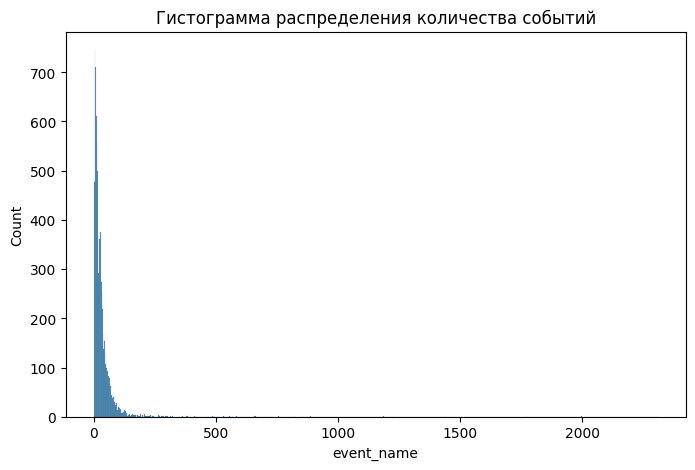

In [18]:
print(f'Медианное количество событий на пользователя равно: {user_event["event_name"].median()}')
print(f'Взглянем на общее описание получившейся таблицы')
print(user_event.describe())
sns.histplot(data=user_event, x='event_name').set_title('Гистограмма распределения количества событий')
plt.show()

По нашей гистограмме и выводу описания столбца мы видимо что у нас наблюдется жирнохвостовое распределение, а также мы видим что медиана отличается от среднего (20 против 32), что означает для нас то, что мы можем предположить что в данных присутствуют выбросы. Ознакомимся с теми данными что резко выбиваются

<AxesSubplot: xlabel='event_name', ylabel='Count'>

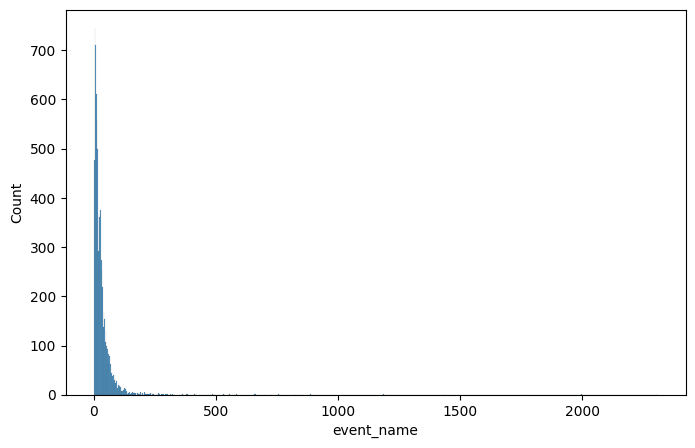

In [19]:
Q1 =  user_event['event_name'].quantile(0.25)
Q3 = user_event['event_name'].quantile(0.75)
IQR = Q3 - Q1
user_event_qt_hard = user_event.query("@Q1 - 1.5*@IQR < event_name < @Q3 + 1.5*@IQR")
sns.histplot(data=user_event, x='event_name')

Если усечь наши данные нормально, то есть по межквартильному размаху, мы получаем отличное распределение, однако, насколько много данных мы потеряли? Проверим это:

In [20]:
print(f'С усечением данных мы потеряли {len(user_event) - len(user_event_qt_hard)} строк или {round((1 - (len(user_event_qt_hard) / len(user_event))) * 100, 2)} %')

С усечением данных мы потеряли 508 строк или 6.73 %


Таким образом, мы делаем вывод, что в нашем датасете пристутствуют выбросы в количестве событий на некоторых пользователей. Причиной такому могут возникнуть:
- боты
- очень активные покупатели, выбивающиеся из общей массы
и предложим рекомендацию о передаче данной информации техническому отделу для рассмотрения.

#### Данные и их период

1. Ответим на вопрос: Данными за какой период мы распологаем?  Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. 
2. Разберемся: Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 
3. Определим, с какого момента данные полные и отбросим более старые. 
4. Определим: данными за какой период времени мы распологаем на самом деле?

Для ответа на  вопросы ознакомимся с столбцом 'event_time_stamp' нашего сета.

В нашем датасете представлены данные с: 2019-07-25 04:43:36 по: 2019-08-07 21:15:17


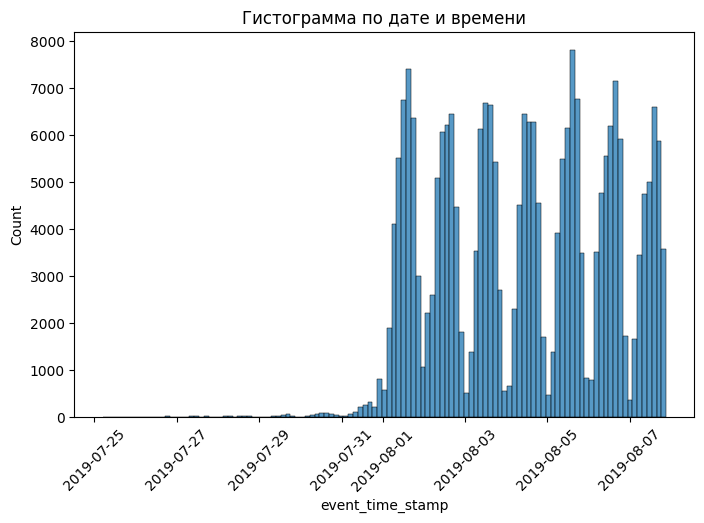

In [21]:
print(f'В нашем датасете представлены данные с: {logs_exp["event_time_stamp"].min()} по: {logs_exp["event_time_stamp"].max()}')
sns.histplot(logs_exp, x='event_time_stamp').set_title('Гистограмма по дате и времени')
plt.xticks(rotation=45)
plt.show()

Не смотря на то, что минимальная дата в нашем сете - 2019-07-25 гистограмма отчетливо дает нам понять, что: Данные за прошлый период до 2019-07-31 наполнены очень слабо, настолько, что в некоторых местах количество близится к нулю, в связи с чем выдвигаем предложение **отсечь данные до 2019-07-31**

Однако перед этим определим, будут ли влиять на наше ислледование пользователи которые будут "доезжать" в наш усеченный датасет, для этого посмотрим на колиество данных в процентном отношении на "заблаговременную" дату, то есть посмотрим сколько данных могут оказаться "некачественными" за 30 число. 

In [22]:
print(f'Процент данных, из которых могут доезжать инфорационные данные в логи равен: {round(len(logs_exp.query("20190730 >= event_date <= 20190731")) / len(logs_exp) * 100,2)} %')

Процент данных, из которых могут доезжать инфорационные данные в логи равен: 0.33 %


Так как процент таких данных минимален, допустим пренебрежение и сделаем срез данных от 2019-07-31 

Теперь в нашем датасете представлены данные с: 2019-07-31 01:11:46 по: 2019-08-07 21:15:17


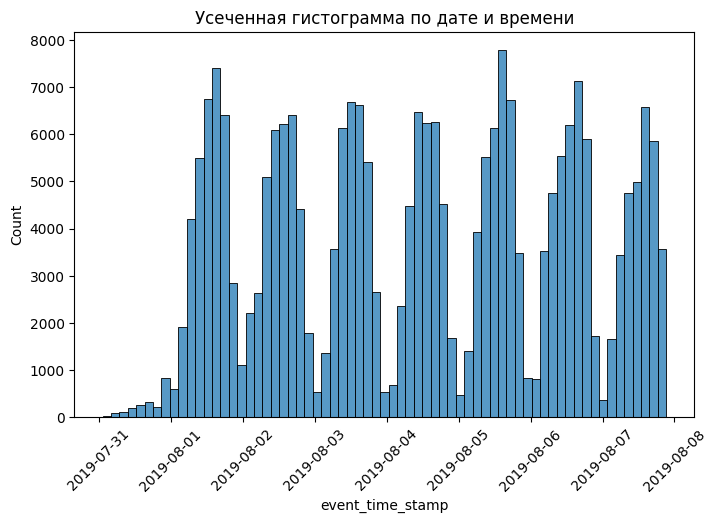

Общий процент утерянных данных после усечения по дате в нашем датасете равен: 0.33%
число удаленных пользователей таким усечением: 9
Таким образом, было пользователей: 7551, стало: 7542


In [23]:
logs_exp_new = logs_exp.query('event_date >= 20190731')
# Взглянем на исправленную гистограмму 
print(f'Теперь в нашем датасете представлены данные с: {logs_exp_new["event_time_stamp"].min()} по: {logs_exp_new["event_time_stamp"].max()}')
sns.histplot(logs_exp_new, x='event_time_stamp').set_title('Усеченная гистограмма по дате и времени')
plt.xticks(rotation=45)
plt.show()
# сразу выведем процент утерянных данных
print(f'Общий процент утерянных данных после усечения по дате в нашем датасете равен: {round((1 - len(logs_exp_new) / len(logs_exp)) * 100, 2) }%')
print(f'число удаленных пользователей таким усечением: {logs_exp["device_id_hash"].nunique() - logs_exp_new["device_id_hash"].nunique()}')
print(f'Таким образом, было пользователей: {logs_exp["device_id_hash"].nunique()}, стало: {logs_exp_new["device_id_hash"].nunique()}')


Теперь данные выглядят более приемлемо, а также процент утерянных данных будем считать допустимым в формате нашего исследования. 

#### Промежуточный вывод

Изначально мы распологали данными за период с: 2019-07-25 04:43:36 по: 2019-08-07 21:15:17, после построения гистограммы стало понятно что данные за период до 2019-07-31 слабо наполнены и не представляют ценности в нашем исследовании, оценив процент теряемых данных (0.33%), а также учтя процент "некачественных" данных из которых могут "доезжать" данные в наш лог (0.33%) мы приняли решение отбросить все данные до 2019-07-31 из нашего сета. 

Теперь мы распологаем данными с: 2019-07-31 01:11:46 по: 2019-08-07 21:15:17

### Воронка событий

1. Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.
2. Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.
3. Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не будем учитывать при расчёте воронки.
4. По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
5. На каком шаге теряем больше всего пользователей?
6. Какая доля пользователей доходит от первого события до оплаты?

#### События в логах и их частота

Для оценки частоты появления событий в логах, а также для оценки видов событий рассмотрим столбец 'event_name' нашего сета

In [24]:
logs_exp_new['event_name'].value_counts().sort_values(ascending=False)

MainScreenAppear           118578
OffersScreenAppear          46707
CartScreenAppear            42560
PaymentScreenSuccessful     34058
Tutorial                     1014
Name: event_name, dtype: int64

Дадим краткое описание каждому из типов событий: 

1. MainScreenAppear - Main screen appear - Открытие главного экрана
2. OffersScreenAppear  -  Offers screen appear - Открытие экрана предложений(товаров)
3. CartScreenAppear - Cart screen appear  - Открытие экрана корзины   
4. PaymentScreenSuccessful - Payment screen successful - Открытие экрана об успешной оплате 
5. Tutorial - Обучение (onboarding) по использованию программы 

Тем самым, мы имеем логично распределившиеся этапы с 1 по 4 включительно с уменьшением пользователей от открытия главного экрана приложения до оплаты покупки

Наименьшее число событий у обучающего раздела, можно предположить что: 
- Интегрирована кнопка "Пропустить обучение" и так, как пользователи считают приложение очень "простым" они в основном пропускают обучение по использованию приложения
- Есть техническая ошибка по причине которой:
    - основной массе пользователей не показывается обучение как таковое
    - нарушен учет пользователей попавших на данных экрана
Предложим рекомендацию уточнить данный пункт у технического отдела, для дальшейшего понимания работы с данными.

#### Пользователи совершаюшие события

Соберем сводную таблицу в которой посмотрим на то, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Также добавим столбец в котором посчитаем количество пользоватей которые хоть раз совершили действием

In [25]:
# соберем необходимую сводную
user_action = logs_exp_new.pivot_table(index='event_name', values='device_id_hash', aggfunc=[ 'nunique']).reset_index()
user_action.columns = ['event_name', 'unique_users'] # переименуем
user_action = user_action.sort_values(by='unique_users', ascending=False) # отсортируем по кол-ву пользователей
user_action

,event_name,unique_users
1,MainScreenAppear,7429
2,OffersScreenAppear,4606
0,CartScreenAppear,3742
3,PaymentScreenSuccessful,3542
4,Tutorial,845


Общее количество пользователей в каждом событии совпадает с общей частотой с которой встречаются эти события в нашем датасете, теперь добавим столбец в котором посчитаем долю пользователей которые хоть раз совершили событие. 

In [26]:
# добавим столбец с подсчетом доли пользователей которые хоть раз совершили события в процентах
user_action['fraction'] = round(user_action['unique_users']/len(logs_exp_new['device_id_hash'].unique()) * 100, 2)
user_action

,event_name,unique_users,fraction
1,MainScreenAppear,7429,98.50
2,OffersScreenAppear,4606,61.07
0,CartScreenAppear,3742,49.62
3,PaymentScreenSuccessful,3542,46.96
4,Tutorial,845,11.20


В целом доли распределились в допустимом разбросе, однако нельзя не заметить то, насколько высокая доля пользователей, которые хоть раз совершили событие в разделе Tutrotial, более 80% от общего числа пользователей посетивших данный раздел. Что дополнительно позволяет нам рекомендовать обратиться в тех. отдел за разъяснениями работы данного раздела.

#### Порядок событий

Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не будем учитывать при расчёте воронки.

Для ответа на данный вопрос повторно вернемся к нашему столбцу с количествами пользователей в каждом разделе

In [27]:
user_action

,event_name,unique_users,fraction
1,MainScreenAppear,7429,98.50
2,OffersScreenAppear,4606,61.07
0,CartScreenAppear,3742,49.62
3,PaymentScreenSuccessful,3542,46.96
4,Tutorial,845,11.20


Мы можем предпложить такую последовательность наступления событий:

0. Открытие приложения (не собираются данные в наш лог) 
1. Появление окна обучения (Tutorial) не для всех пользователей -> 
2. Появление главного экрана (MainScreenAppear) -> 
3. Появление экрана предложений (OffersScreenAppear) -> 
4. Появление окна корзины (CartScreenAppear) -> 
5. Появление окна об успешной оплате (PaymentScreenSuccessful)

В наших логах все данные складываются в логичную цепочку от появления главного экрана до покупки за исключением раздела Tutorial который явно выбивается из общей картины. Предположения по нему мы выдвигали ранее. 

#### Построение воронки событий

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

Для ответа на вопросы нашего исследования построим воронку событий и изучим её.
Однако перед этим, проведем фильтрацию по разделу Tutorial, так как он вызывает больше всего вопросов. 

In [28]:
user_action_fun = user_action.query('event_name != "Tutorial"').reset_index(drop=True)
user_action_fun

,event_name,unique_users,fraction
0,MainScreenAppear,7429,98.50
1,OffersScreenAppear,4606,61.07
2,CartScreenAppear,3742,49.62
3,PaymentScreenSuccessful,3542,46.96


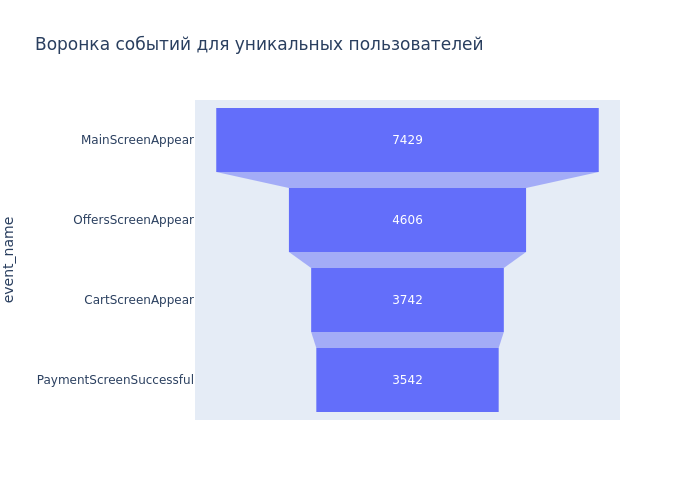

In [29]:
fig = px.funnel(user_action_fun, x='unique_users', y='event_name', title='Воронка событий для уникальных пользователей',)
fig.show()

Также таблично представим данные нашей таблицы и сразу добавим столбцы с подсчетом потери количества уникальных пользователей на каждом этапе, а также доли этих пользователей.

In [30]:
# сразу добавим первую строку нового столбца для удобства
user_action_fun.loc[0, 'cr_step'] = user_action_fun.loc[0, 'unique_users']/user_action_fun.loc[0, 'unique_users']*100
for i in range(1, len(user_action_fun)):
    user_action_fun.loc[i, 'cr_step'] = user_action_fun.loc[i, 'unique_users']/user_action_fun.loc[i-1, 'unique_users']*100
user_action_fun['cr_step'] = round(user_action_fun['cr_step'], 2)
user_action_fun

,event_name,unique_users,fraction,cr_step
0,MainScreenAppear,7429,98.50,100.00
1,OffersScreenAppear,4606,61.07,62.00
2,CartScreenAppear,3742,49.62,81.24
3,PaymentScreenSuccessful,3542,46.96,94.66


По данным о долях переходящих на каждый следующий этап мы видим логичное распределение, не все пользователи увидевшие главные экран переходят к экрану предложений(открыли приложение по ошибке/ознакомительно скачали в первый раз и т.д.), а далее пользователь "вовлекается" в совершение новых событий, и почти 95% пользователей добавивших товары в корзину переходят к оплате. 

#### Потеря количества пользователей по шагам

Для определения шага с наибольшими потерями количества пользователей, рассчитаем аналогичную прошлому шагу величину в количественном отношении. 

In [31]:
# сразу добавим первую строку нового столбца для удобства
user_action_fun.loc[0, 'user_loss'] = user_action_fun.loc[0, 'unique_users'] - user_action_fun.loc[0, 'unique_users']
for i in range(1, len(user_action_fun)):
    user_action_fun.loc[i, 'user_loss'] = user_action_fun.loc[i, 'unique_users'] - user_action_fun.loc[i-1, 'unique_users']
user_action_fun['user_loss'] = abs(user_action_fun['user_loss'])
user_action_fun

,event_name,unique_users,fraction,cr_step,user_loss
0,MainScreenAppear,7429,98.50,100.00,0.0
1,OffersScreenAppear,4606,61.07,62.00,2823.0
2,CartScreenAppear,3742,49.62,81.24,864.0
3,PaymentScreenSuccessful,3542,46.96,94.66,200.0


In [32]:
print(f'Максимальная потеря пользователей равная {user_action_fun["user_loss"].max()}')
print(f'Что соответсвует индексу строки {user_action_fun.index[user_action_fun["user_loss"]==2823.0].tolist()}')
print(f'Данные потери происходят при переходе с шага {user_action_fun["event_name"][0]} на шаг {user_action_fun["event_name"][1]}')

Максимальная потеря пользователей равная 2823.0
Что соответсвует индексу строки [1]
Данные потери происходят при переходе с шага MainScreenAppear на шаг OffersScreenAppear


Данный результат является вполне обоснованным тем, что не все пользователи увидевшие главные экран переходят к экрану предложений(открыли приложение по ошибке/ознакомительно скачали в первый раз и т.д.)

#### Доля пользователей от первого события до оплаты

Для подчета данного пункта, соотнесем количество уникальных пользователей в последнем этапе (оплаты) и первом этапе (открытие главного экрана)

In [33]:
print(f'Доля пользователей от первого события до оплаты в процентах равна: {round(user_action_fun["unique_users"][3] / user_action_fun["unique_users"][0] * 100, 2)} %')

Доля пользователей от первого события до оплаты в процентах равна: 47.68 %


Практически половина пользователей доходят от показа главного экрана. 

#### Промежуточный вывод

- Краткое описание каждого из типов событий:

    - MainScreenAppear - Main screen appear - Открытие главного экрана
    - OffersScreenAppear  -  Offers screen appear - Открытие экрана предложений(товаров)
    - CartScreenAppear - Cart screen appear  - Открытие экрана корзины
    - PaymentScreenSuccessful - Payment screen successful - Открытие экрана об успешной оплате
    - Tutorial - Обучение (onboarding) по использованию программы
Тем самым, мы имеем логично распределившиеся этапы с 1 по 4 включительно с уменьшением пользователей от открытия главного экрана приложения до оплаты покупки

- Наименьшее число событий у обучающего раздела, можно предположить что:

    - Интегрирована кнопка "Пропустить обучение" и так, как пользователи считают приложение очень "простым" они в основном пропускают обучение по использованию приложения
    - Есть техническая ошибка по причине которой:
        - основной массе пользователей не показывается обучение как таковое
        - нарушен учет пользователей попавших на данных экрана
Предложим рекомендацию уточнить данный пункт у технического отдела, для дальшейшего понимания работы с данными.

- Мы можем предпложить такую последовательность наступления событий:

0. Открытие приложения (не собираются данные в наш лог)
1. Появление окна обучения (Tutorial) не для всех пользователей ->
2. Появление главного экрана (MainScreenAppear) ->
3. Появление экрана предложений (OffersScreenAppear) ->
4. Появление окна корзины (CartScreenAppear) ->
5. Появление окна об успешной оплате (PaymentScreenSuccessful)
В наших логах все данные складываются в логичную цепочку от появления главного экрана до покупки за исключением раздела Tutorial который явно выбивается из общей картины. Предположения по нему мы выдвигали ранее.

Для ответа на вопросы нашего исследования построили воронку событий и изучили её.
Однако перед этим, провели фильтрацию по разделу Tutorial, так как он вызывает больше всего вопросов и большей долей вероятности не является обязательным.

По данным о долях переходящих на каждый следующий этап мы видим логичное распределение, не все пользователи увидевшие главные экран переходят к экрану предложений(открыли приложение по ошибке/ознакомительно скачали в первый раз и т.д.), а далее пользователь "вовлекается" в совершение новых событий, и почти 95% пользователей добавивших товары в корзину переходят к оплате.
Практически половина пользователей доходят от показа главного экрана. 

### Результаты исследования

- Ответим на вопрос: "Сколько пользователей в каждой экспериментальной группе?"
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий (удобно обернем проверку в отдельную функцию). Опрделим: "Можно ли сказать, что разбиение на группы работает корректно?"
- Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Ответим на вопросы: "Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы."

#### Количество пользователей в каждой экспериментальной группе

Для ответа на вопрос о количестве пользователей в каждой группе соберем сводную таблицу и сделаем выводы. 

In [34]:
logs_exp_new.head()

,event_name,device_id_hash,event_time_stamp,exp_id,event_date
797,MainScreenAppear,3670880358399219515,2019-07-31 01:11:46,247,2019-07-31
798,OffersScreenAppear,3799109751993694887,2019-07-31 01:21:04,248,2019-07-31
799,Tutorial,1126021718529336913,2019-07-31 01:32:11,247,2019-07-31
800,MainScreenAppear,4293428370257583636,2019-07-31 02:19:18,248,2019-07-31
801,MainScreenAppear,4567464647598975872,2019-07-31 02:33:30,247,2019-07-31


In [35]:
group_users = logs_exp_new.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique').reset_index()
group_users

,exp_id,device_id_hash
0,246,2485
1,247,2517
2,248,2540


Напомним, что: 246 и 247 — контрольные группы, а 248 — экспериментальная.

#### Корректность механизмов и расчетов

Напомним критерии успешного A/A-теста:
1. Количество пользователей в различных группах различается не более, чем на 1%;
2. Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
3. Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
4. Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Представим ответ на данный раздел чек-листом и пойдем поэтапно
- Мы будем сравнивать пользователей групп 246 и 247 
- Различие количества пользователей проверим ниже



In [36]:
print(f'Количество пользователей в различных группах различается на {round(((group_users["device_id_hash"][1] - group_users["device_id_hash"][0]) / group_users["device_id_hash"][1]) * 100, 2)} % ')

Количество пользователей в различных группах различается на 1.27 % 


- Данное различие в первом пункте проверки успешности теста не проходит порог в 1%. Однако, заметим, что разница в количестве уникальных пользователей влияет скорее на скорость сбора данных, чем на их качество. Очевидно, что чем меньше разница в количестве уникальных пользователей в группах - тем быстрей будет перейден порог в количестве необходимых пользователей в каждой группе. Однако, если эта разница выше 1% - это не повод отказываться от АА и АВ-тестов на собранных данных.
- Данные фиксируемые для всех групп об одном и том же.
- Проверим различие ключевой метрики между двумя группами,а именно выполним проверку гипотезы о равенстве долей для конечного выявления нахождения/отсутствия статистическими критериями разницы между выборками 246 и 247.

In [37]:
# Соберем сводную в которой рассмотрим каждое событие в разрезе групп
exp_event = logs_exp_new.pivot_table(index='exp_id',columns = 'event_name', values='device_id_hash',aggfunc='nunique').reset_index()
del exp_event['Tutorial'] # удалим данный столбец
# добавим столбец с общим количеством уникальных пользователей в каждой группе
exp_event['Total'] = [group_users['device_id_hash'][0], group_users['device_id_hash'][1], group_users['device_id_hash'][2]]
exp_event

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
0,246,1267,2452,1544,1200,2485
1,247,1239,2479,1526,1159,2517
2,248,1236,2498,1536,1183,2540


In [38]:
# Напишем функцию для проверки гипотез
def test_result (success, trials, alpha):
    # пропорция успехов в первой группе:
    p1 = success[0] / trials[0]
    # пропорция успехов во второй группе:
    p2 = success[1] / trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2
 
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        print('')
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [39]:
# Напишем функцию, которая на вход получает порядковый номер группы в таблице и параметр стат.значимости, и возвращает результаты проверки гипотез
def checker (group_a, group_b, alpha):
    alpha_test = alpha
    count_users = ([exp_event['Total'][group_a], exp_event['Total'][group_b]])
    count_MainScreenAppear = ([exp_event['MainScreenAppear'][group_a], exp_event['MainScreenAppear'][group_b]])
    count_OffersScreenAppear = ([exp_event['OffersScreenAppear'][group_a], exp_event['OffersScreenAppear'][group_b]])
    count_CartScreenAppear = ([exp_event['CartScreenAppear'][group_a], exp_event['CartScreenAppear'][group_b]])
    count_PaymentScreenSuccessful = ([exp_event['PaymentScreenSuccessful'][group_a], exp_event['PaymentScreenSuccessful'][group_b]])
    
    print('Результаты теста по долям count_users и count_MainScreenAppear для групп')
    test_result(count_MainScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_OffersScreenAppear и count_users для групп')
    test_result(count_OffersScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_users и count_CartScreenAppear для групп')
    test_result(count_CartScreenAppear, count_users, alpha_test)
    
    print('Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп')
    test_result(count_PaymentScreenSuccessful, count_users, alpha_test)


Составим нулевую и альтернативную гипотезы:

Н0 - Доли в выборках равны
Н1 - Доли в выборках различаются 

А также поясним, что рекомендуемый статистический уровен значимости равен 0.1 

В данном этапе не будем производить его изменений, так как критический уровень стат значимости стандартно имеет разброс и мы взглянем на результаты при таком уровне вероятности найти разницу - 10%

In [40]:
# Выполним проверку 246 и 247 контрольных групп с alpha = 0.1

checker (0, 1, 0.1)

Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.5868776836512959
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.2743505991932964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.21306131796590932
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.11210845100173072
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Получаем результат, по которому статистические критерии не находят  разницу между выборками 246 и 247.
Во всех результатах теста не получилось отвергнуть нулевую гипотезу, которая гласит о том, что доли в выборках равны. Тем самым считаем что, контрольные группы выбраны верно. 

#### Самое популярное событие

Выберем самое популярное событие. 
Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. 
Посчитаем долю пользователей, совершивших это событие. 
Проверим, будет ли отличие между группами статистически достоверным. 
Проделаем то же самое для всех других событий (удобно обернем проверку в отдельную функцию). 
Определим: "Можно ли сказать, что разбиение на группы работает корректно?"

Для того, чтобы выбрать самое популярное событие повторно взглянем на нашу таблицу с количеством уникальных пользователей в разрезе по группам и событиям

In [41]:
exp_event

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
0,246,1267,2452,1544,1200,2485
1,247,1239,2479,1526,1159,2517
2,248,1236,2498,1536,1183,2540


Как и предполагалось, самое популярное событие - MainScreenAppear, то есть открытие главного экрана, в разных группах его совершило:
- Группа 246 - 2452 пользователя
- Группа 247 - 2479 пользователя
- Группа 248 - 2498 пользователя

Рассчитаем долю пользователей совершивших это событие по отношению к общему количеству пользователей в группе ниже:

In [42]:
for i in range(len(exp_event)):
    print(f'Доля пользователей совершивших открытие главного экрана в группе {exp_event["exp_id"][i]} в процентах равно: {round(exp_event["MainScreenAppear"][i] / exp_event["Total"][i] * 100, 2)}% ')

Доля пользователей совершивших открытие главного экрана в группе 246 в процентах равно: 98.67% 
Доля пользователей совершивших открытие главного экрана в группе 247 в процентах равно: 98.49% 
Доля пользователей совершивших открытие главного экрана в группе 248 в процентах равно: 98.35% 


Результаты деления подтверждают лидерство популярности данного события.

--- 

Проверку достоверности статистического отличия в контрольных группах __проводили__ в шаге:  "Корректность механизмов и расчетов" получили результат о том, что : Статистические критерии не находят разницу между контрольными выборками 246 и 247. 

В данном случае на вопрос: "Можно ли сказать, что разбиение на группы работает корректно?" 
Можно ответить - Да. Разделение на контрольные группы в данном тесте работает корректно. 

#### Группа с измененным шрифтом

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [43]:
# Сразу создадим в нашей таблице exp_event объединенную группу
exp_event.loc[3] = ['246+247', exp_event['CartScreenAppear'][0] + exp_event['CartScreenAppear'][1] , exp_event['MainScreenAppear'][0] + exp_event['MainScreenAppear'][1], exp_event['OffersScreenAppear'][0] + exp_event['OffersScreenAppear'][1], exp_event['PaymentScreenSuccessful'][0] + exp_event['PaymentScreenSuccessful'][1], exp_event['Total'][0] + exp_event['Total'][1]]
exp_event

event_name,exp_id,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
0,246,1267,2452,1544,1200,2485
1,247,1239,2479,1526,1159,2517
2,248,1236,2498,1536,1183,2540
3,246+247,2506,4931,3070,2359,5002


In [44]:
print('Выполним проверку групп А1/B (246 и 248) при alpha=10%')
checker (0, 2, 0.1)
print('---')
print('Выполним проверку групп А2/B (247 и 248) при alpha=10%')
checker (1, 2, 0.1)
print('---')
print('Выполним проверку групп А/B (246+247 и 248) при alpha=10%')
checker (3, 2, 0.1)

Выполним проверку групп А1/B (246 и 248) при alpha=10%
Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.341286386031747
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.22699680075034445
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.09941721664866177
Отвергаем нулевую гипотезу: между долями есть значимая разница

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.22352231840506898
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---
Выполним проверку групп А2/B (247 и 248) при alpha=10%
Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.681958382603927
Не получилось отвергнуть нулевую гипотезу, нет осн

Итого, по результатам проверок, при alpha = 10%, нет оснований считать группы разными, за исключением сравнения групп 246 и 248, то есть первой контрольной и экспериментальной в разделе с экраном появления корзины (CartScreenAppear). Между долями данных групп пристутствуют статистически значимые различия. 

#### Изменим статистическую значимость

Ответим на вопросы: "Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы."

В проверке выше использовали уровень статистической значимости рекомендованный, равный 10%
Было сделано 16 проверок. 
В проверках ниже будем использовать уровень значимости равный 5% то есть alpha = 0.05 
Проделаем еще раз все проверки и сравним выводы.

In [45]:
print('Выполним проверку А1/А2 (246 и 247) контрольных групп при alpha = 5%')
checker (0, 1, 0.05)
print('-'*15)
print('Выполним проверку групп А1/B (246 и 248) при alpha=5%')
checker (0, 2, 0.05)
print('-'*15)
print('Выполним проверку групп А2/B (247 и 248) при alpha=5%')
checker (1, 2, 0.05)
print('-'*15)
print('Выполним проверку групп А/B (246+247 и 248) при alpha=5%')
checker (3, 2, 0.05)

Выполним проверку А1/А2 (246 и 247) контрольных групп при alpha = 5%
Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.5868776836512959
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_OffersScreenAppear и count_users для групп
p-значение:  0.2743505991932964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_users и count_CartScreenAppear для групп
p-значение:  0.21306131796590932
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям count_PaymentScreenSuccessful и count_users для групп
p-значение:  0.11210845100173072
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

---------------
Выполним проверку групп А1/B (246 и 248) при alpha=5%
Результаты теста по долям count_users и count_MainScreenAppear для групп
p-значение:  0.341286386031747
Не получил

При проверке с данным уровнем стат. значимости получаем следующий результат во всех 16 проверках:
Не получилось отвергнуть нулевую гипотезу по всем результатм, нет оснований считать доли разными ни в одной из групп. 

### Общий вывод

В данном исследовании мы:
- Выполнили открытие данных и произвели первичную оценку предстоящей работы по предобработке
- Провели полную работу по предобработке данных:
    - Привели названия столбцов к нижнему регистру и разделить знаками "_"
    - Изменили типы данных в столбцах
    - Добавили отдельный столбец дат
    - Выполнили проверку пропусков и дубликатов (явных и неявных) во всех данных нашего проекта
    - Проверили данные на наличие ошибок (некорректных дат в столбцах дат, и отрицательных или резко - выброшенных значений в числовых столбцах)
    - пересекающиеся пользователи между экспериментальными группа не найдены, можно продолжать исследование

- По результатам изучения и проверки данных:
    - Дали краткое описание каждого из типов событий:
        - MainScreenAppear - Main screen appear - Открытие главного экрана
        - OffersScreenAppear  -  Offers screen appear - Открытие экрана предложений(товаров)
        - CartScreenAppear - Cart screen appear  - Открытие экрана корзины
        - PaymentScreenSuccessful - Payment screen successful - Открытие экрана об успешной оплате
        - Tutorial - Обучение (onboarding) по использованию программы
    - Тем самым, мы имеем логично распределившиеся этапы с 1 по 4 включительно с уменьшением пользователей от открытия главного экрана приложения до оплаты покупки
    - Наименьшее число событий у обучающего раздела, выдвинули предположение, что:
        - Интегрирована кнопка "Пропустить обучение" и так, как пользователи считают приложение очень "простым" они в основном пропускают обучение по использованию приложения
         - Есть техническая ошибка по причине которой:
            - основной массе пользователей не показывается обучение как таковое
            - нарушен учет пользователей попавших на данных экрана
    - Предложили рекомендацию уточнить данный пункт у технического отдела, для дальшейшего понимания работы с данными.

- По результатам изучения воронки событий:
    - Мы предположили такую последовательность наступления событий:
        0. Открытие приложения (не собираются данные в наш лог)
        1. Появление окна обучения (Tutorial) не для всех пользователей ->
        2. Появление главного экрана (MainScreenAppear) ->
        3. Появление экрана предложений (OffersScreenAppear) ->
        4. Появление окна корзины (CartScreenAppear) ->
        5. Появление окна об успешной оплате (PaymentScreenSuccessful)
    - В наших логах все данные складываются в логичную цепочку от появления главного экрана до покупки за исключением раздела Tutorial который явно выбивается из общей картины. Предположения по нему мы выдвигали ранее.
    - Для ответа на вопросы нашего исследования построили воронку событий и изучили её.
Однако перед этим, провели фильтрацию по разделу Tutorial, так как он вызывает больше всего вопросов и большей долей вероятности не является обязательным.
    - По данным о долях переходящих на каждый следующий этап мы видим логичное распределение, не все пользователи увидевшие главные экран переходят к экрану предложений(открыли приложение по ошибке/ознакомительно скачали в первый раз и т.д.), а далее пользователь "вовлекается" в совершение новых событий, и почти 95% пользователей добавивших товары в корзину переходят к оплате.
Практически половина пользователей доходят от показа главного экрана. 

- По результатам исследования:
    - Определили количество пользователей в каждой группе: 
        - в группе 246 - 2485 пользователя
        - в группе 247 - 2517 
        - в группе 248 - 2540
    - Проверили корректность работы механизмов и расчетов при отборе контрольных А/А групп:
        - Приняли успешность данного отбора не смотря на различие в группах более 1% (1.27%)
    - Составили нулевую и альтернативную гипотезы для проверки контрольных групп и остальных проверок:
        - Н0 - Доли в выборках равны
        - Н1 - Доли в выборках различаются
    - Выполнили проверки ключевых метрик z-тестом (основанием для выбора считаем то, что: Z-тест относится к одномерному статистическому анализу, который не проверяет гипотезу о том, что пропорции двух независимых выборок сильно различаются. Он определяет, в какой степени точка знания далека от своего среднего значения информационного множества, в дисперсии. А также, размеры выборок слишком велики для t-теста) 
        - Произвели проверки между всеми группам по ключевым метрикам (доли переходов пользователей по экранам приложения)
        - Выполнили 16 проверок со стат. значимостью 10 % и 16 проверок со значимостью 5 %
        - Получили результат о том, что: 
            - по результатам проверок, при alpha = 10%, нет оснований считать группы разными, за исключением сравнения групп 246 и 248, то есть первой контрольной и экспериментальной в разделе с экраном появления корзины (CartScreenAppear). Между долями данных групп пристутствуют статистически значимые различия.
            - При проверке с уровнем стат. значимости равным alpha = 5 % получаем следующий результат во всех 16 проверках:
Не получилось отвергнуть нулевую гипотезу по всем результатм, нет оснований считать доли разными ни в одной из групп. 

Подведем итог данного исследования тем, что: мы подтвердили, что наши контрольные группы равны. Тем самым мы дополнительно подкрепили свою уверенность в точности проводимых экспериментов. Однако, не смотря на то что при повышенном уровне стат значимости мы наблюдаем определенный положительный рост в переходах в экспериментальной группе, как только мы снижаем данный уровень до общеприемлимых 5% мы получаем результат с полным отсутствием статистических различий между группами. Можем предположить финально, что менять шрифт не имеет смысла. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8ddfa18a-2107-434c-989d-50c5ec648d01' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>